In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [3]:
import pyro
import muvi

In [4]:
%matplotlib
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [5]:
# plotting settings
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [6]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:2'

In [7]:
DATA_PATH = Path("../../../data/muvi/mixscape_hvg_filter.h5ad")

In [8]:
adata = sc.read_h5ad(DATA_PATH)
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 17645 × 2000
    obs: 'GenePair', 'Phase', 'gene', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'mixscape_class_p_ko', 'mixscape_class', 'mixscape_class_global', 'pertclass'
    var: 'ENSEMBL', 'ENTREZID', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'mixscape', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_pert', 'normal_counts'
    obsp: 'connectivities', 'distances'

<Axes: >

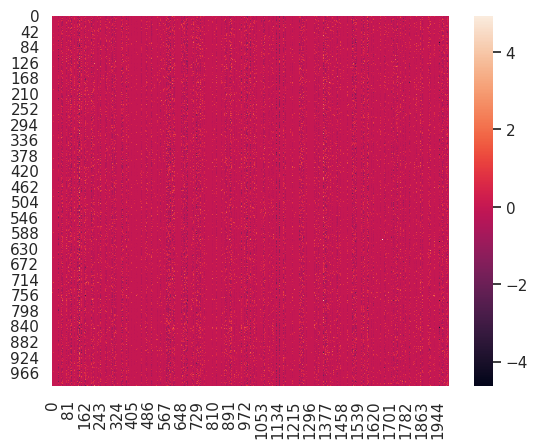

In [9]:
sns.heatmap(adata.to_df().sample(1000).values)

In [10]:
adata.X = adata.layers["normal_counts"].copy()
adata

AnnData object with n_obs × n_vars = 17645 × 2000
    obs: 'GenePair', 'Phase', 'gene', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'mixscape_class_p_ko', 'mixscape_class', 'mixscape_class_global', 'pertclass'
    var: 'ENSEMBL', 'ENTREZID', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'mixscape', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_pert', 'normal_counts'
    obsp: 'connectivities', 'distances'

<Axes: ylabel='Count'>

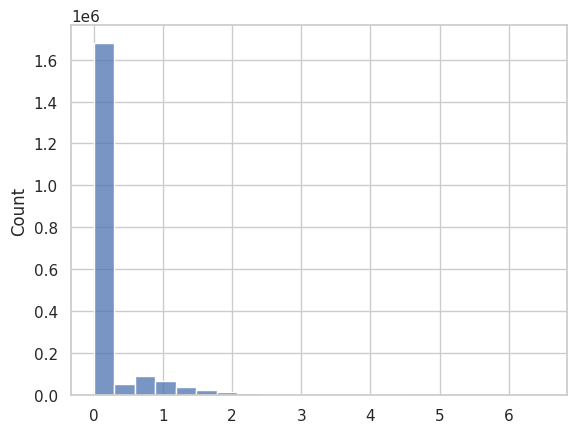

In [11]:
sns.histplot(adata.to_df().sample(1000).values.flatten())

<Axes: >

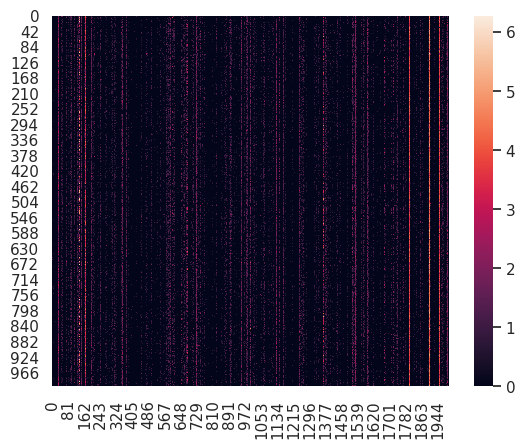

In [12]:
sns.heatmap(adata.to_df().sample(1000).values)

In [13]:
adata.obs

,GenePair,Phase,gene,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,mixscape_class_p_ko,mixscape_class,mixscape_class_global,pertclass
L2_ACACCAATCGATACGT,GATA2_KDM1A,G1,"GATA2,KDM1A",2675,2674,9646.0,610.0,6.323865,3,1.000000,"GATA2,KDM1A KO",KO,strong
L3_GAGATGGTCATTTGTC,HDAC3_INTS1,G1,"HDAC3,INTS1",3043,3043,9197.0,469.0,5.099489,2,0.660242,"HDAC3,INTS1 KO",KO,strong
L4_AAGAACACATCTCGTC,DOT1L_INTS1,G2M,"DOT1L,INTS1",4074,4074,15692.0,1380.0,8.794290,2,0.553298,"DOT1L,INTS1 KO",KO,strong
L4_TAGACTGCACTACTTT,INTS1_SMARCD1,G1,"INTS1,SMARCD1",2444,2444,6093.0,599.0,9.830954,2,0.607024,"INTS1,SMARCD1 KO",KO,strong
L2_AGGGAGTAGGACCCAA,NT_NT,G2M,CTRL,4030,4030,16312.0,1339.0,8.208681,4,0.000000,CTRL,CTRL,CTRL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
L2_AGCGTCGCATGACCCG,HDAC3_NT,G2M,HDAC3,1327,1327,2376.0,162.0,6.818182,1,0.998739,HDAC3 KO,KO,strong
L3_AAGTTCGGTAATCAAG,RCOR1_VPRBP,G1,"RCOR1,VPRBP",1564,1564,3643.0,357.0,9.799616,11,0.994534,"RCOR1,VPRBP KO",KO,strong
L2_AAGATAGGTTCTAACG,FLI1_IKZF1,G1,"FLI1,IKZF1",2755,2755,8695.0,518.0,5.957447,5,0.999999,"FLI1,IKZF1 KO",KO,strong
L4_ATTCATCTCGTTACCC,DOT1L_GATA2,G1,"DOT1L,GATA2",2883,2883,8667.0,630.0,7.268951,2,0.788472,"DOT1L,GATA2 KO",KO,strong


In [14]:
adata.obs["gene"].unique()

['GATA2,KDM1A', 'HDAC3,INTS1', 'DOT1L,INTS1', 'INTS1,SMARCD1', 'CTRL', ..., 'MED22,MED24', 'MED14,MED19', 'SUPT16H,SUPT5H', 'MED16', 'GATA2']
Length: 167
Categories (167, object): ['ATXN7L3', 'CD14', 'CTRL', 'DOT1L', ..., 'SUPT5H,SUPT6H', 'SUPT16H', 'SUPT16H,SUPT5H', 'SUPT16H,SUPT6H']

In [15]:
# random_samples = np.random.choice(adata.obs_names, size=10000, replace=False)
# random_features = np.random.choice(adata.var_names, size=3000, replace=False)
# # adata = adata[random_samples, :].copy()
# adata

In [16]:
hallmark_collection = muvi.fs.from_gmt(
    "../msigdb/h.all.v7.5.1.symbols.gmt", name="hallmark"
)
reactome_collection = muvi.fs.from_gmt(
    "../msigdb/c2.cp.reactome.v7.5.1.symbols.gmt", name="reactome"
)
# merge both collections
gene_set_collection = hallmark_collection | reactome_collection
gene_set_collection

<FeatureSets 'hallmark|reactome' with 1665 feature sets>

We keep only those gene set annotations with at least 40 genes, and where at least 20% of the genes are available in the set of genes from RNA.

In [17]:
gene_set_collection = gene_set_collection.filter(
    adata.var_names, min_fraction=0.2, min_count=15
)
gene_set_collection

<FeatureSets 'hallmark|reactome' with 42 feature sets>

In [18]:
def prettify(name, max_len=50):
    def prettify_single(name, max_len):
        if "dense" in name:
            return name
        parts = name.split("_")[1:]
        new_name = " ".join(parts)
        if len(new_name) > max_len:
            half_len = (max_len) // 2
            new_name = new_name[: half_len - 2] + "..." + new_name[-half_len + 1 :]
        new_name = f"{new_name} ({name[0]})"
        return new_name.title()

    parts = name.split("|")
    max_len = max_len // len(parts)
    return "|".join([prettify_single(part, max_len) for part in parts])

for gs in gene_set_collection:
    gs.name = prettify(gs.name)

In [19]:
adata.varm["gene_set_mask"] = gene_set_collection.to_mask(adata.var_names.tolist()).T
adata.varm["gene_set_mask"].shape

(2000, 42)

In [20]:
cond_cov = pd.get_dummies(adata.obs["gene"]) * 1.0
cond_cov

,ATXN7L3,CD14,CTRL,DOT1L,"DOT1L,EP300","DOT1L,FLI1","DOT1L,GATA2","DOT1L,GFI1","DOT1L,GSE1","DOT1L,HDAC3",...,SMARCD1,"SMARCD1,SSRP1","SMARCD1,VPRBP","SSRP1,SUPT16H","SSRP1,VPRBP",SUPT5H,"SUPT5H,SUPT6H",SUPT16H,"SUPT16H,SUPT5H","SUPT16H,SUPT6H"
L2_ACACCAATCGATACGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L3_GAGATGGTCATTTGTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L4_AAGAACACATCTCGTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L4_TAGACTGCACTACTTT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L2_AGGGAGTAGGACCCAA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L2_AGCGTCGCATGACCCG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L3_AAGTTCGGTAATCAAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L2_AAGATAGGTTCTAACG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L4_ATTCATCTCGTTACCC,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Informed Latent Decomposition

For this analysis we use the prior information from [Reactome](https://reactome.org/) which has already been stored inside `adata.varm['gene_set_mask']`.

In [21]:
model = muvi.tl.from_adata(
    adata,
    prior_mask_key="gene_set_mask",
    view_names=["rna"],
    prior_confidence="med",
    n_factors=1,
    condition_covs=cond_cov.values,
    nmf=True,
    device=device,
)
model

2025-03-01 21:08:09,255 - muvi.core.models - WARNING - Running MuVI on a single view.
2025-03-01 21:08:09,257 - muvi.core.models - INFO - pd.DataFrame detected.
2025-03-01 21:08:09,258 - muvi.core.models - INFO - Storing the index of the view `rna` as sample names.
2025-03-01 21:08:09,262 - muvi.core.models - INFO - pd.DataFrame detected.
2025-03-01 21:08:09,264 - muvi.core.models - INFO - pd.DataFrame detected.
2025-03-01 21:08:09,268 - muvi.core.models - INFO - Storing the index of the mask `rna` as factor names.
2025-03-01 21:08:09,271 - muvi.core.models - INFO - Likelihoods set to `{'rna': 'normal'}`.
2025-03-01 21:08:09,271 - muvi.core.models - INFO - NMF set to `{'rna': True}`.
2025-03-01 21:08:09,272 - muvi.core.models - INFO - Normalizing observations.
2025-03-01 21:08:09,273 - muvi.core.models - INFO - Setting min value of view `rna` to 0.
2025-03-01 21:08:09,533 - muvi.core.models - INFO - Setting global standard deviation to 1.0 (from 0.532).
2025-03-01 21:08:09,546 - muvi.c

|================================|
|       MuVI version 0.2.0       |
|================================|
| Parameter        | Value       |
|------------------|-------------|
| n_views          | 1           |
| n_samples        | 17645       |
| n_features       | rna: 2000   |
| n_factors        | 43          |
| prior_confidence | 0.995       |
| n_covariates     | 0           |
| likelihoods      | rna: normal |
| nmf              | rna: True   |
| reg_hs           | True        |
| pos_transform    | relu        |
| device           | cuda:2      |
|================================|

In [22]:
# _, training_data = model.fit(seed=0, batch_size=1000, n_epochs=200)
# training_data = {k: v.to(model.device) for k, v in training_data.items()}
# training_data["sample_idx"] = None
# pyro.render_model(model._model, model_kwargs=training_data)

In [23]:
model.fit(seed=0)

2025-03-01 21:08:09,638 - muvi.core.models - INFO - Preparing model and guide...
2025-03-01 21:08:09,703 - muvi.core.models - INFO - Preparing optimizer...
2025-03-01 21:08:09,704 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2025-03-01 21:08:09,705 - muvi.core.models - INFO - Preparing SVI...
2025-03-01 21:08:09,706 - muvi.core.models - INFO - Preparing training data...
2025-03-01 21:08:09,782 - muvi.core.models - INFO - Using complete dataset.
2025-03-01 21:08:09,832 - muvi.core.models - INFO - Setting training seed to `0`.
2025-03-01 21:08:09,835 - muvi.core.models - INFO - Cleaning parameter store.
2025-03-01 21:08:09,835 - muvi.core.models - INFO - Starting training...


  0%|                                                 | 0/10000 [00:00<?, ?it/s]

2025-03-01 21:08:10,643 - root - INFO - Guessed max_plate_nesting = 2


 13%|███▍                       | 1257/10000 [01:27<10:09, 14.33it/s, ELBO=-510]

Relative improvement of -0.002142 < 1e-05 for 10 step(s) in a row, stopping early.
2025-03-01 21:09:37,540 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


## Downstream Analysis

Once the training terminates, we may call `muvi.tl.foo` followed by `muvi.pl.foo` to apply different analysis tools and plot the results, similar to the usage principles of `scanpy`.

Under the hood, `muvi` stores every intermediate result in a `model._cache.factor_adata` such as variance explained by each factor, significance of each factor with respect to the prior information and so on.

In [24]:
# to speed up the process, use a random subsample to approximate the variance explained
r2_view, r2_factor, _ = muvi.tl.variance_explained(model, subsample=1000)
r2_view

2025-03-01 21:09:38,300 - muvi.tools.utils - INFO - Estimating `r2` with a random sample of 1000 samples.
2025-03-01 21:09:38,336 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


/home/aqoku/miniforge3/envs/muvi_ext/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


{'rna': np.float32(0.7623632)}

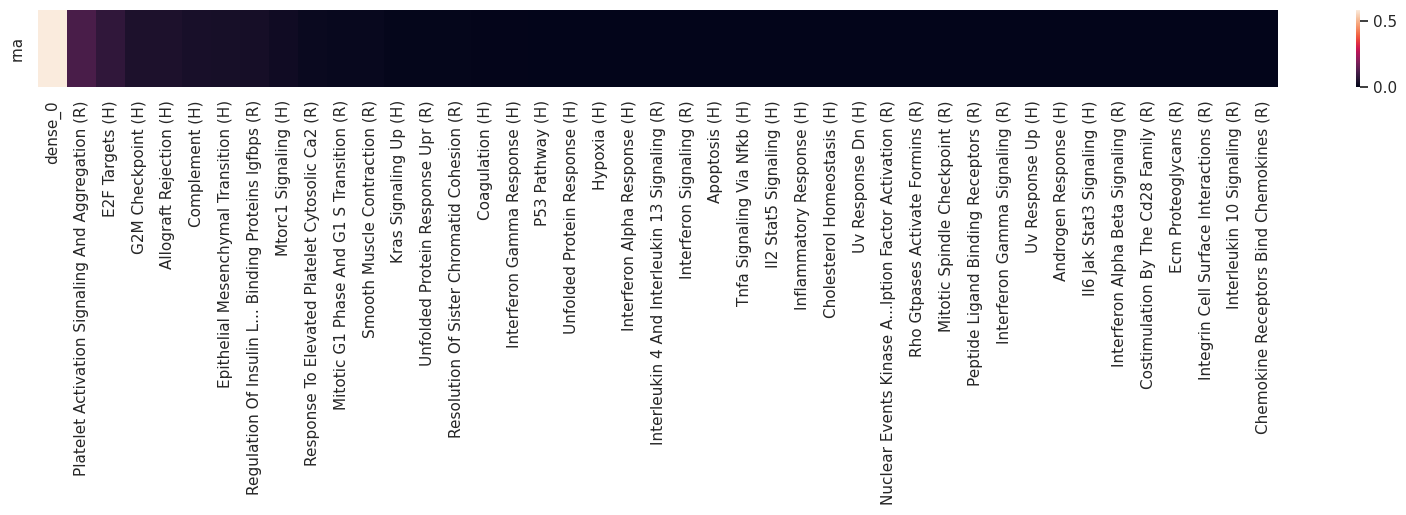

<Axes: >

In [25]:
muvi.pl.variance_explained(model)

Next, we perform a statistical test ([PCGSE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4543476/)) to determine how well the inferred factors match the prior information representing each pathway. Here, we apply a correlation adjusted one-sided t-test, and correcting for multiple testing. 

Unless we provide other feature sets, e.g. [Gene Ontology](http://geneontology.org/), `muvi` automatically compares each inferred factor against its corresponding prior gene set annotation.

In [26]:
_ = muvi.tl.test(model)

2025-03-01 21:09:39,941 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 86.31it/s]

2025-03-01 21:09:40,490 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.




00%|███████████████████████████████████████████| 42/42 [00:00<00:00, 75.54it/s]

Now we may plot an overview of the most relevant factors by combining the variance explained and the results of the statistical test. Since we applied a one-sided hypothesis test, each significant factor is marked by a `(+)` or `(-)` indicating the significance direction. A factor may also be significant in both directions. However, we report the more significant direction based on the lower p-value.

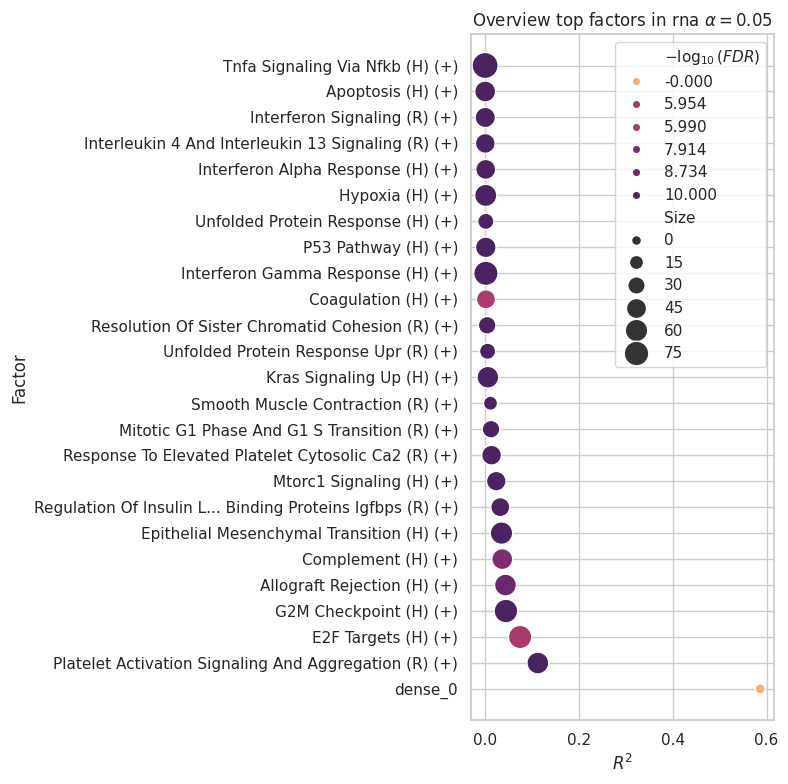

(<Figure size 800x800 with 1 Axes>,
 array([[<Axes: title={'center': 'Overview top factors in rna $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>]],
       dtype=object))

In [27]:
muvi.pl.factors_overview(model)

In [28]:
# add obs metadata
model._cache.factor_adata.obs = adata.obs.copy()

After copying the metadata stored in `adata.obs`, we may perform a typical `scanpy` analysis such as computing a neighborhood graph in the latent space, applying a clustering algorithm on the pathway level, and embedding the neighborhood graph in two dimensions for visualization purposes.

Optionally, we may filter only the relevant factors before performing the steps mentioned above. This is useful to reduce the number of factors involved in the analysis by removing factors that explain little to no variance in the data.

In [29]:
muvi.tl.filter_factors(model)

2025-03-01 21:09:41,989 - muvi.tools.utils - INFO - Filtering down to 11 factors.
2025-03-01 21:09:41,992 - muvi.tools.cache - INFO - Factors filtered successfully.


True

In [30]:
model._cache.factor_adata.obs

,GenePair,Phase,gene,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,mixscape_class_p_ko,mixscape_class,mixscape_class_global,pertclass
L2_ACACCAATCGATACGT,GATA2_KDM1A,G1,"GATA2,KDM1A",2675,2674,9646.0,610.0,6.323865,3,1.000000,"GATA2,KDM1A KO",KO,strong
L3_GAGATGGTCATTTGTC,HDAC3_INTS1,G1,"HDAC3,INTS1",3043,3043,9197.0,469.0,5.099489,2,0.660242,"HDAC3,INTS1 KO",KO,strong
L4_AAGAACACATCTCGTC,DOT1L_INTS1,G2M,"DOT1L,INTS1",4074,4074,15692.0,1380.0,8.794290,2,0.553298,"DOT1L,INTS1 KO",KO,strong
L4_TAGACTGCACTACTTT,INTS1_SMARCD1,G1,"INTS1,SMARCD1",2444,2444,6093.0,599.0,9.830954,2,0.607024,"INTS1,SMARCD1 KO",KO,strong
L2_AGGGAGTAGGACCCAA,NT_NT,G2M,CTRL,4030,4030,16312.0,1339.0,8.208681,4,0.000000,CTRL,CTRL,CTRL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
L2_AGCGTCGCATGACCCG,HDAC3_NT,G2M,HDAC3,1327,1327,2376.0,162.0,6.818182,1,0.998739,HDAC3 KO,KO,strong
L3_AAGTTCGGTAATCAAG,RCOR1_VPRBP,G1,"RCOR1,VPRBP",1564,1564,3643.0,357.0,9.799616,11,0.994534,"RCOR1,VPRBP KO",KO,strong
L2_AAGATAGGTTCTAACG,FLI1_IKZF1,G1,"FLI1,IKZF1",2755,2755,8695.0,518.0,5.957447,5,0.999999,"FLI1,IKZF1 KO",KO,strong
L4_ATTCATCTCGTTACCC,DOT1L_GATA2,G1,"DOT1L,GATA2",2883,2883,8667.0,630.0,7.268951,2,0.788472,"DOT1L,GATA2 KO",KO,strong


Now we can proceed to perform clustering on top of the inferred and filtered latent space.

In [31]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model)
muvi.tl.umap(model)

/home/aqoku/projects/code_new/MuVI/muvi/tools/utils.py:817: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return cluster_fn(setup_cache(model).factor_adata, **kwargs)


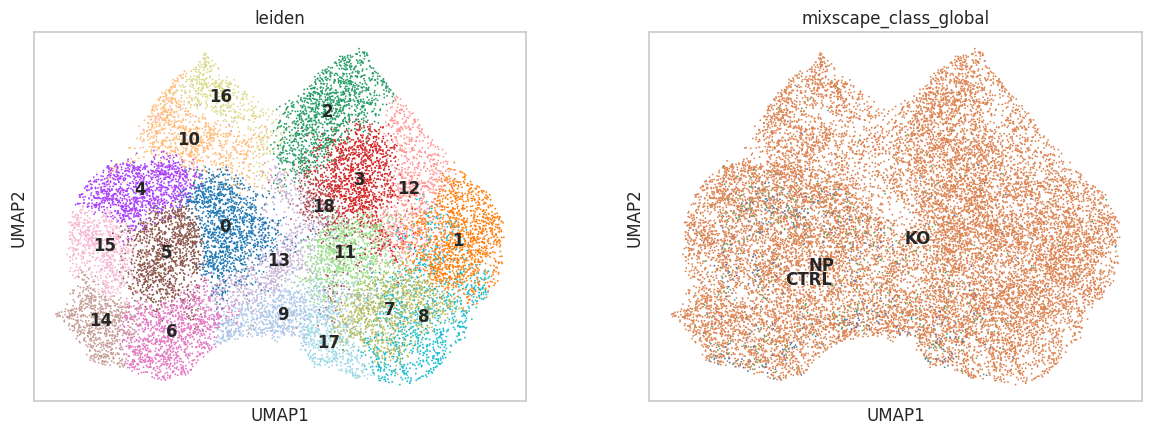

In [33]:
muvi.pl.umap(model, color=["leiden", "mixscape_class_global"], legend_loc="on data")

The inferred latent space captures major axes of variation such as different conditions or cell types. Next, we look into specific factors (pathways) that explain variance between both conditions. 

2025-03-01 21:10:50,167 - muvi.tools.plotting - WARNING - dendrogram data not found (using `dendrogram_mixscape_class_global` as key). Running `muvi.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `muvi.tl.dendrogram` independently.


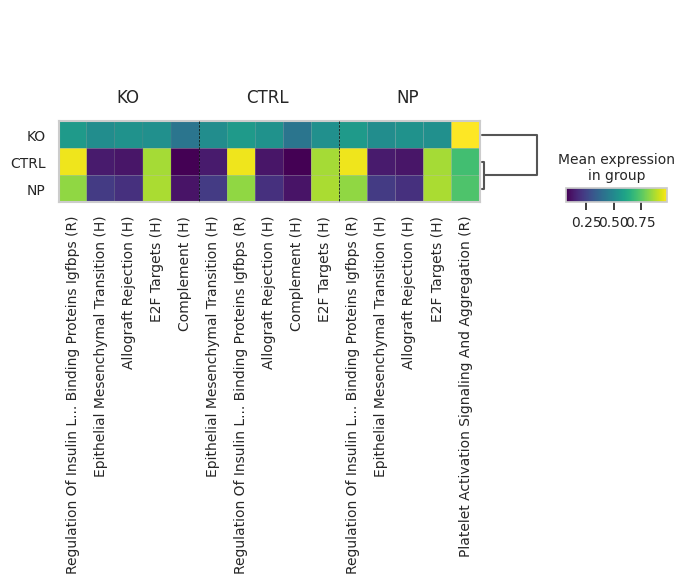

<Axes: >

In [34]:
muvi.tl.rank(model, "mixscape_class_global", method="wilcoxon")
muvi.pl.rank(
    model, n_factors=5, pl_type="matrixplot", swap_axes=False
)

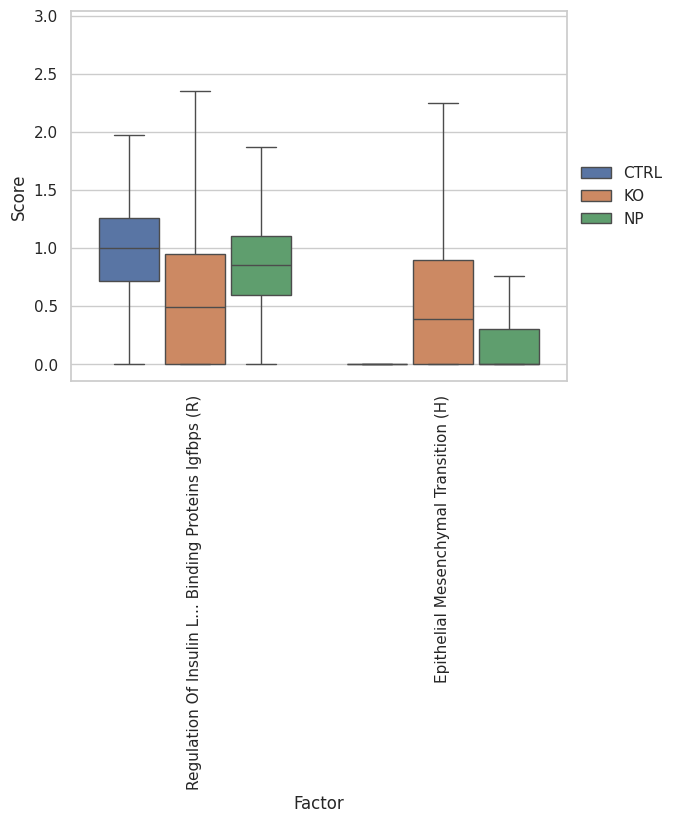

In [36]:
top_cond_factors, _ = muvi.pl.groupplot_rank(model, pl_type="boxplot", top=1, fliersize=0, gap=0.1, rot=90)

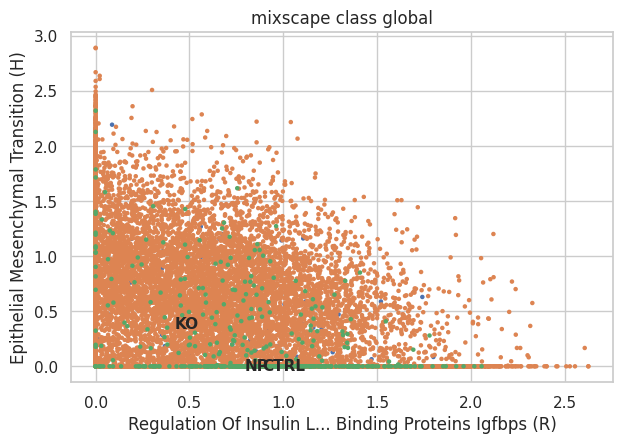

In [37]:
muvi.pl.scatter(
    model,
    top_cond_factors[0],
    top_cond_factors[1],
    "mixscape_class_global",
    size=42,
    legend_loc="on data",
)

In [38]:
import pyro

In [39]:
pyro.get_param_store().get_param("MuVI._guide.locs.w_condition").cpu().detach().numpy()[:, model.factor_order].shape

(167, 43)

In [40]:
condition_w = pd.DataFrame(pyro.get_param_store().get_param("MuVI._guide.locs.w_condition").cpu().detach().numpy()[:, model.factor_order].T, index=model.factor_names, columns=cond_cov.columns)
condition_w.head()

,ATXN7L3,CD14,CTRL,DOT1L,"DOT1L,EP300","DOT1L,FLI1","DOT1L,GATA2","DOT1L,GFI1","DOT1L,GSE1","DOT1L,HDAC3",...,SMARCD1,"SMARCD1,SSRP1","SMARCD1,VPRBP","SSRP1,SUPT16H","SSRP1,VPRBP",SUPT5H,"SUPT5H,SUPT6H",SUPT16H,"SUPT16H,SUPT5H","SUPT16H,SUPT6H"
dense_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Platelet Activation Signaling And Aggregation (R),0.382482,0.634618,0.705598,0.795387,1.484407,0.983615,0.840570,0.606473,0.725447,0.610736,...,1.061669,1.175911,1.148084,1.338022,1.068477,1.242018,1.009825,1.076423,1.368536,1.402225
E2F Targets (H),0.784841,0.890669,0.797156,0.628552,-0.001560,0.119094,0.688477,0.164422,0.384110,0.705716,...,0.371506,0.390954,0.530589,-0.165858,0.314436,-0.073602,0.338760,0.393485,-0.239171,-0.007514
G2M Checkpoint (H),0.564219,0.690462,0.405667,0.298484,-0.108560,0.047790,0.251602,0.104041,0.170314,0.262017,...,0.245044,0.251417,0.294222,-0.396183,0.163304,-0.018238,0.147019,0.144340,-0.173626,-0.102015
Allograft Rejection (H),-0.444754,-0.091726,-0.168808,0.102435,0.605751,0.688948,0.108791,0.350590,0.251959,0.235517,...,0.403968,0.336944,0.407355,0.604967,0.097061,0.559284,0.439777,0.576945,0.780817,0.806880


<Figure size 2000x2000 with 0 Axes>

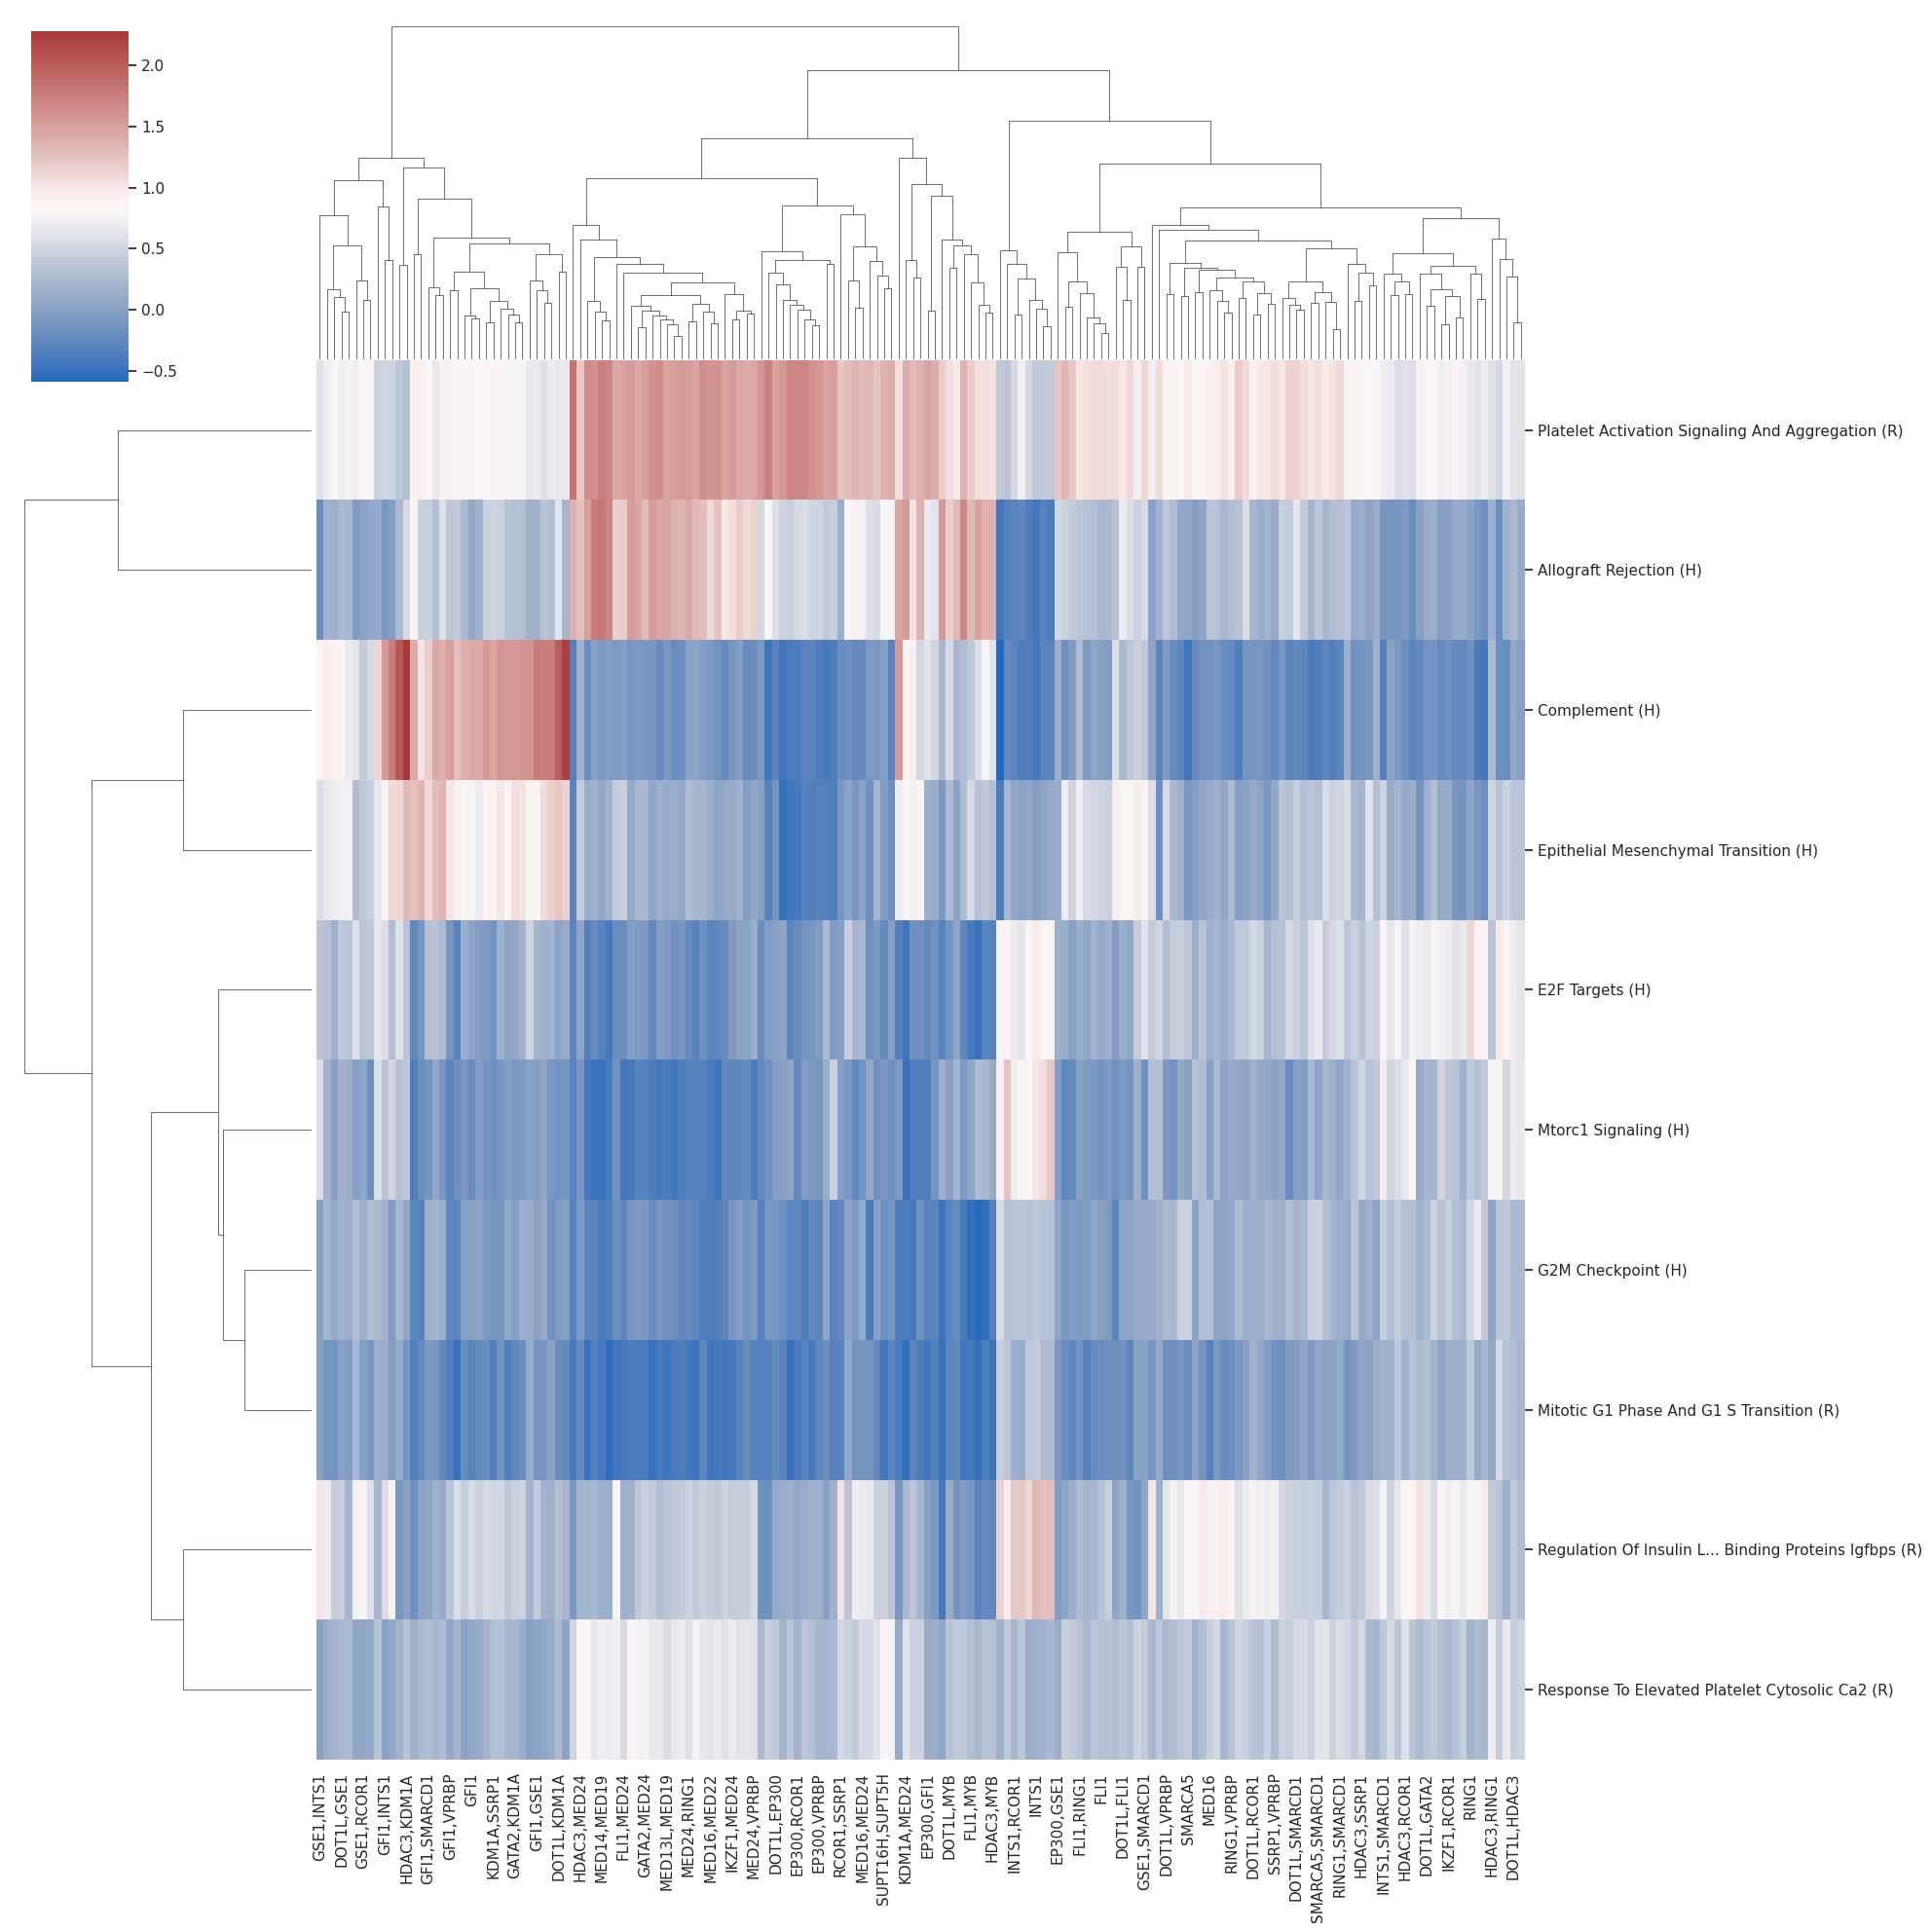

In [41]:
# sns.clustermap(condition_w.iloc[1:21, :], yticklabels=True, xticklabels=True)
plt.figure(figsize=(20, 20))
sns.clustermap(condition_w.loc[model._cache.factor_adata.obsm["filtered_scores"].columns[model.n_dense_factors:], :], figsize=(20, 20), yticklabels=True, cmap=sns.color_palette("vlag", as_cmap=True))

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

In [43]:
# Compute cosine similarity across rows
cols = model._cache.factor_adata.obsm["filtered_scores"].columns[model.n_dense_factors:]

cosine_sim = cosine_similarity(condition_w.loc[cols, :].T)

# Convert to DataFrame for readability
cosine_sim_df = pd.DataFrame(cosine_sim, index=condition_w.columns, columns=condition_w.columns)

/home/aqoku/miniforge3/envs/muvi_ext/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/aqoku/miniforge3/envs/muvi_ext/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


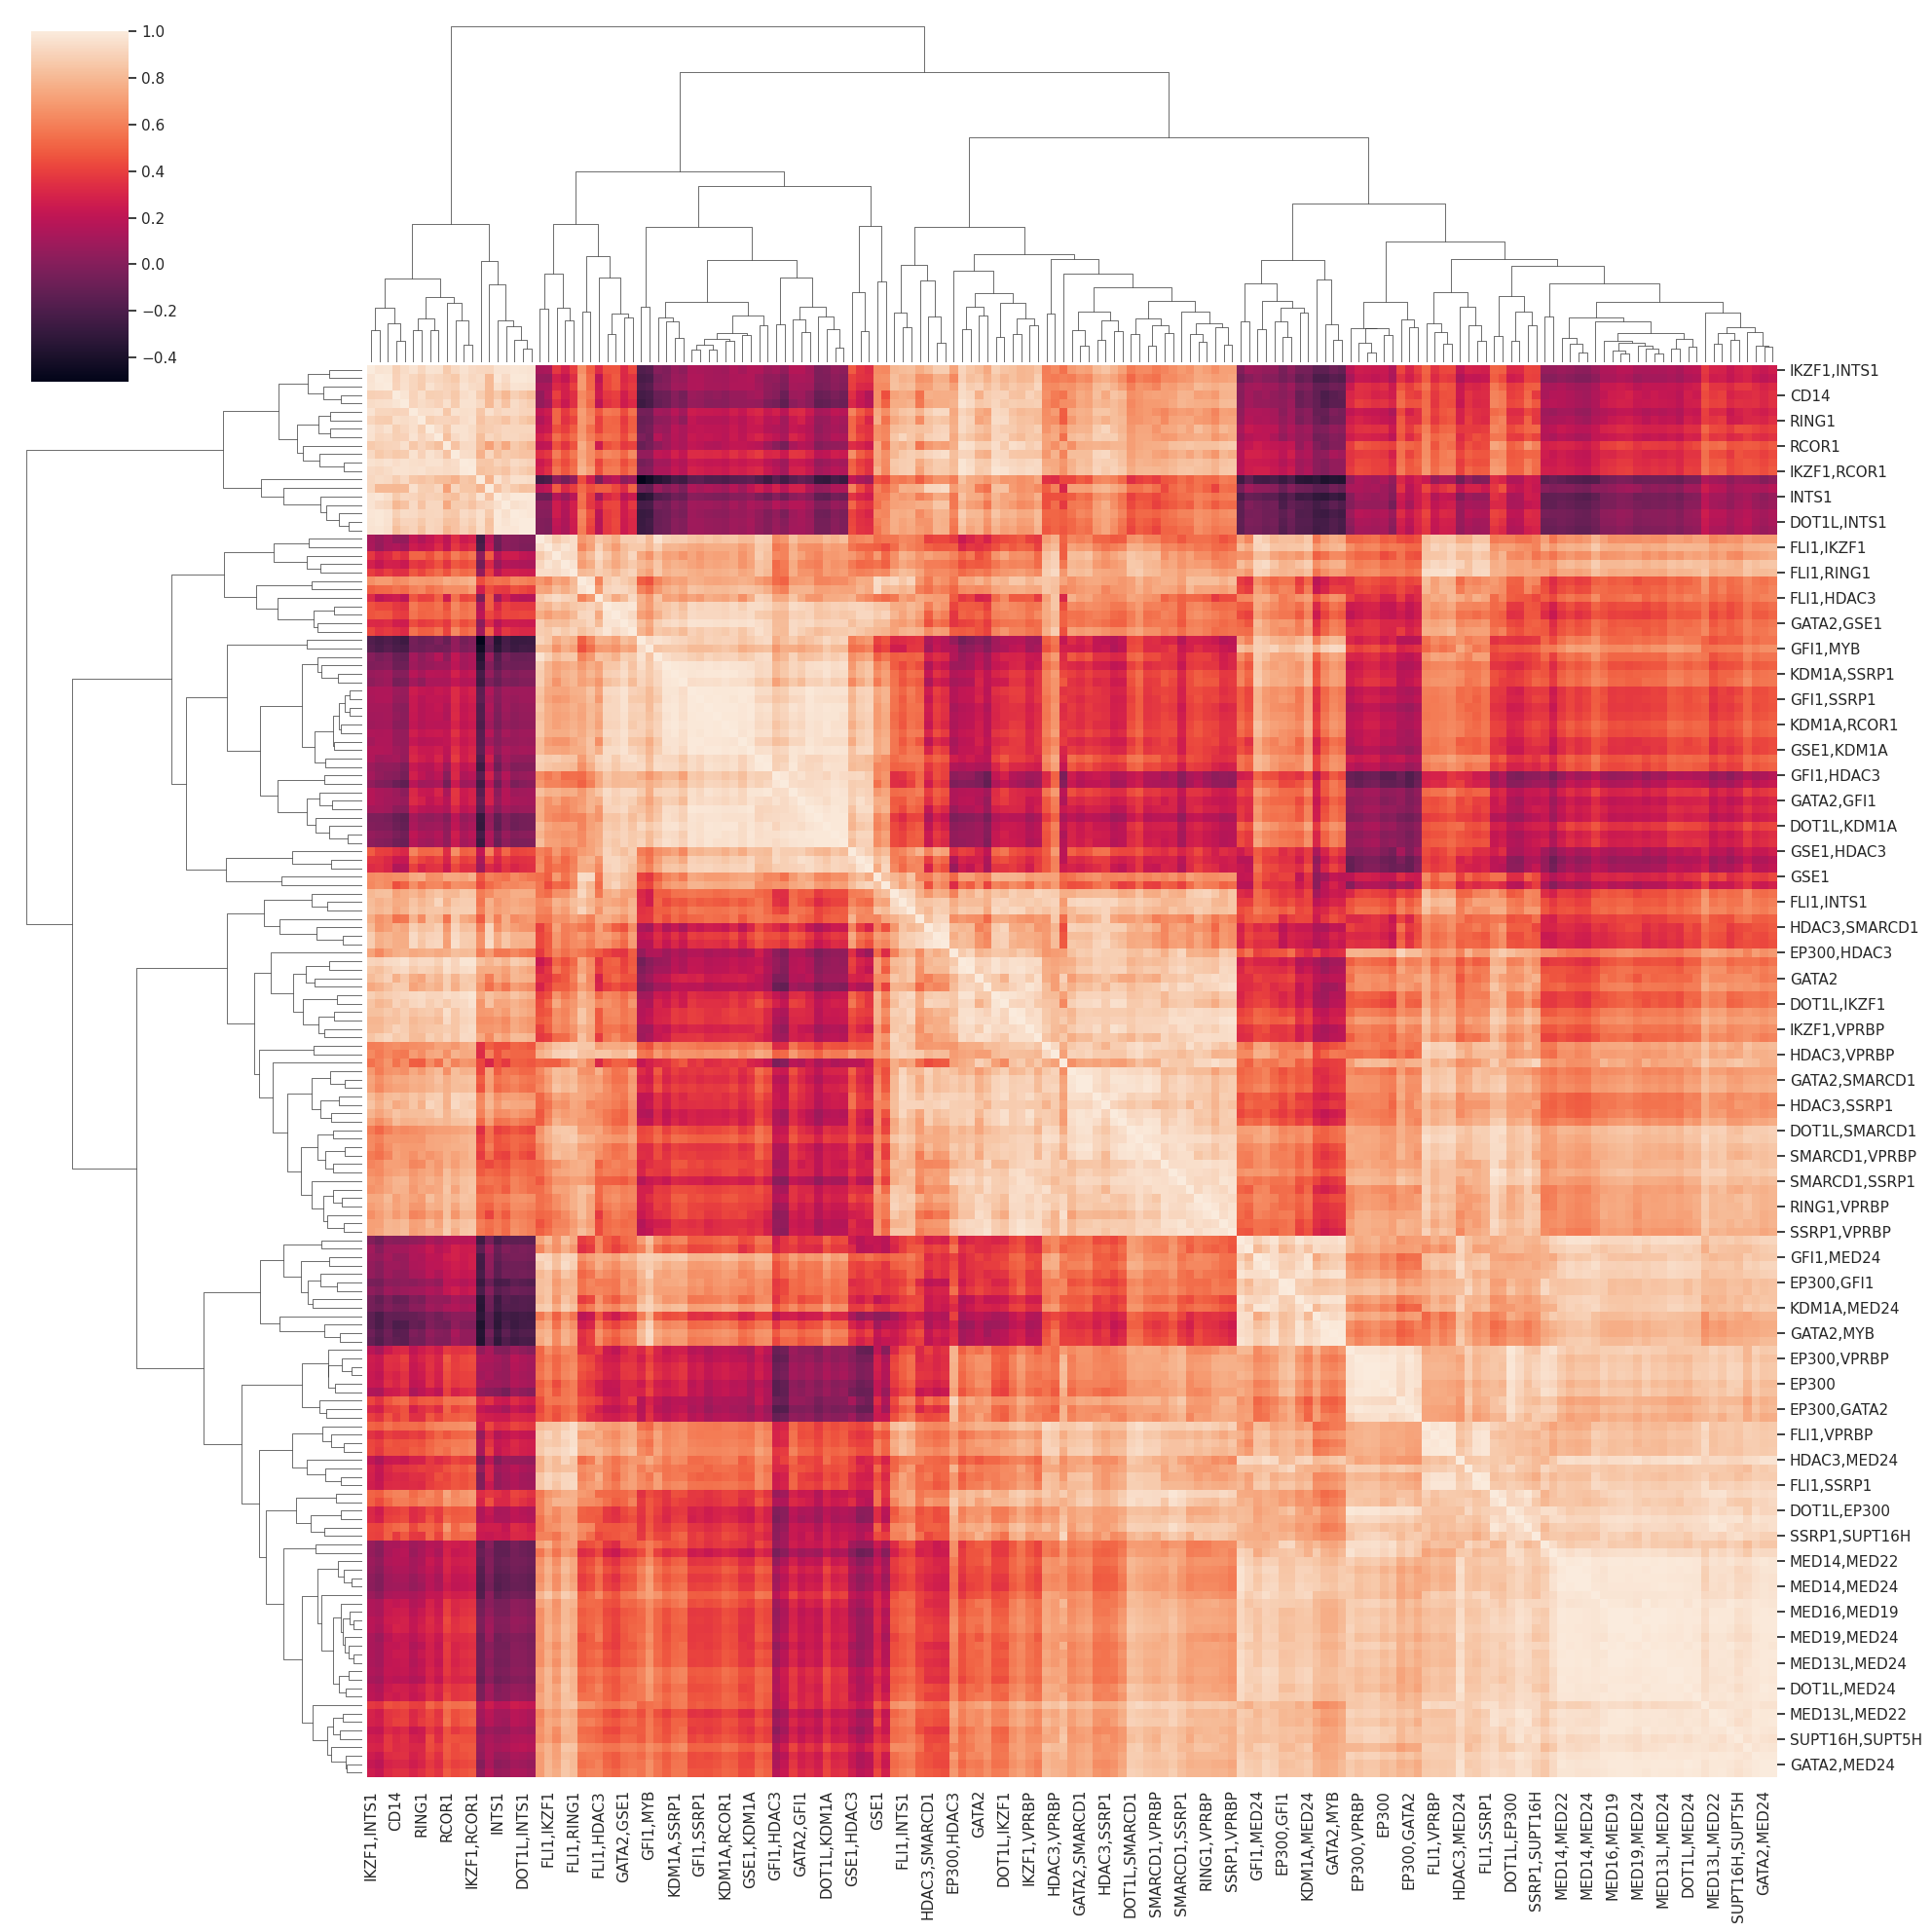

In [44]:
clustergrid = sns.clustermap(cosine_sim_df, figsize=(20, 20))

In [46]:
# sim_conditions = cosine_sim_df.index[clustergrid.dendrogram_row.reordered_ind][-40:].tolist()
# sns.clustermap(cosine_sim_df.loc[sim_conditions, sim_conditions], figsize=(20, 20))

In [48]:
# sns.clustermap(cosine_sim_df.loc[relevant_conditions, relevant_conditions], figsize=(20, 20))

In [ ]:
# sns.clustermap(condition_w.loc[model._cache.factor_adata.obsm["filtered_scores"].columns[model.n_dense_factors:], :].corr().loc[relevant_conditions, relevant_conditions])

In [ ]:
ifn_genes = ["JAK1", "IFNGR1", "JAK2", "STAT1", "IFNGR2"]
model._cache.factor_adata.obs["IFN_gene"] = model._cache.factor_adata.obs["gene"].astype(str)
model._cache.factor_adata.obs.loc[~model._cache.factor_adata.obs["IFN_gene"].isin(ifn_genes), "IFN_gene"] = np.nan
model._cache.factor_adata.obs["IFN_gene"] = model._cache.factor_adata.obs["IFN_gene"].astype("category")

In [ ]:
del model._cache.factor_adata.uns["IFN_gene_colors"]

In [ ]:
model._cache.factor_adata.obs

In [ ]:
muvi.pl.umap(model, color=["condition", "IFN_gene"], s=16)

In [ ]:
sns.clustermap(condition_w.loc[model._cache.factor_adata.obsm["filtered_scores"].columns[model.n_dense_factors:], ifn_genes], figsize=(10, 20), yticklabels=True, cmap=sns.color_palette("vlag", as_cmap=True))

In [ ]:
plt.figure(figsize=(10, 2))
fac_name = top_cond_factors[0]
pos_weights = condition_w.loc[fac_name, :].sort_values(ascending=False).iloc[:20]
neg_weights = condition_w.loc[fac_name, :].sort_values(ascending=False).iloc[-20:]
top_weights_vector = pd.concat([pos_weights, neg_weights])
top_weights_vector.index = top_weights_vector.index.astype(str)
ax = sns.barplot(top_weights_vector)
ax.set(ylim=(-0.5, 0.5))
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(10, 2))
cond_name = "JAK1"
pos_weights = condition_w[cond_name].sort_values(ascending=False).iloc[:20]
neg_weights = condition_w[cond_name].sort_values(ascending=False).iloc[-20:]
ax = sns.barplot(pd.concat([pos_weights, neg_weights]))
ax.set(ylim=(-0.5, 0.5))
plt.xticks(rotation=90)
plt.show()

In [ ]:
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

In [ ]:
condition_w_scale = pd.DataFrame(pyro.get_param_store().get_param("MuVI._guide.scales.w_condition").cpu().detach().numpy()[:, model.factor_order].T, index=model.factor_names, columns=cond_cov.columns)
condition_w_scale.head()

In [ ]:
cond_cov.shape

In [ ]:
# Compute predictions for all targets
Z_pred = cond_cov @ condition_w.T  # (n x p) @ (p x m) = (n x m)
Z_pred.shape

In [ ]:
# Compute residuals
E = model.get_factor_scores() - Z_pred  # (n x m)
E.shape

In [ ]:
# Compute Residual Covariance Matrix (for multiple outputs)
sigma_squared = (E.T @ E) / (model.n_samples - model.n_features["rna"])  # (m x m) covariance matrix
sigma_squared.shape

In [ ]:
# Compute t-statistics
t_stats = condition_w / condition_w_scale  # (p x m)
t_stats.shape

In [ ]:
# Compute p-values using the t-distribution
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=model.n_samples - model.n_features["rna"]))
p_values = pd.DataFrame(p_values, index=t_stats.index, columns=t_stats.columns)
p_values.shape

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(p_values < 0.05)

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(p_values.loc[:, relevant_conditions] < 0.05)

In [ ]:
# p_values.apply(lambda row: multipletests(row, method="bonferroni")[1], axis=0)
plt.figure(figsize=(20, 20))
sns.heatmap(p_values.apply(lambda row: multipletests(row, method="fdr_bh")[1], axis=0) < 0.05)

In [ ]:
# p_values.apply(lambda row: multipletests(row, method="bonferroni")[1], axis=0)
plt.figure(figsize=(20, 20))
sns.heatmap(p_values.apply(lambda row: multipletests(row, method="fdr_bh")[1], axis=0).loc[:, relevant_conditions] < 0.05)